# setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%%capture
!pip install git+https://github.com/EleutherAI/sae.git

In [ ]:
# you should load this before cloning repo files
# from .config import SaeConfig
# from .utils import decoder_impl

from sae.config import SaeConfig
from sae.utils import decoder_impl
from sae import Sae

Triton not installed, using eager implementation of SAE decoder.


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
from fnmatch import fnmatch
from pathlib import Path
from typing import NamedTuple, Optional, Callable, Union, List, Tuple
# from jaxtyping import Float, Int

import einops
import torch
from torch import Tensor, nn
from huggingface_hub import snapshot_download
from natsort import natsorted
from safetensors.torch import load_model, save_model

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from collections import Counter

## corr fns

In [ ]:
def batched_correlation(reshaped_activations_A, reshaped_activations_B, batch_size=100):
    # Ensure tensors are on GPU
    if torch.cuda.is_available():
        reshaped_activations_A = reshaped_activations_A.to('cuda')
        reshaped_activations_B = reshaped_activations_B.to('cuda')

    # Normalize columns of A
    mean_A = reshaped_activations_A.mean(dim=0, keepdim=True)
    std_A = reshaped_activations_A.std(dim=0, keepdim=True)
    normalized_A = (reshaped_activations_A - mean_A) / (std_A + 1e-8)  # Avoid division by zero

    # Normalize columns of B
    mean_B = reshaped_activations_B.mean(dim=0, keepdim=True)
    std_B = reshaped_activations_B.std(dim=0, keepdim=True)
    normalized_B = (reshaped_activations_B - mean_B) / (std_B + 1e-8)  # Avoid division by zero

    num_batches = (normalized_B.shape[1] + batch_size - 1) // batch_size
    max_values = []
    max_indices = []

    for batch in range(num_batches):
        start = batch * batch_size
        end = min(start + batch_size, normalized_B.shape[1])
        batch_corr_matrix = torch.matmul(normalized_A.t(), normalized_B[:, start:end]) / normalized_A.shape[0]
        max_val, max_idx = batch_corr_matrix.max(dim=0)
        max_values.append(max_val)
        # max_indices.append(max_idx + start)  # Adjust indices for the batch offset
        max_indices.append(max_idx)  # Adjust indices for the batch offset

        del batch_corr_matrix
        torch.cuda.empty_cache()

    return torch.cat(max_indices), torch.cat(max_values)

## sim fns

In [ ]:
import functools
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(
    R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad"
) -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def sim_random_baseline(
    rep1: torch.Tensor, rep2: torch.Tensor, sim_func: Callable, n_permutations: int = 10
) -> Dict[str, Any]:
    torch.manual_seed(1234)
    scores = []
    for _ in range(n_permutations):
        perm = torch.randperm(rep1.size(0))

        score = sim_func(rep1[perm, :], rep2)
        score = score if isinstance(score, float) else score["score"]

        scores.append(score)

    return {"baseline_scores": np.array(scores)}


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray], Dict[str, Any]],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray) -> Dict[str, Any]:
        for preprocess_func in self.preprocess_funcs:
            R = preprocess_func(R)
            Rp = preprocess_func(Rp)
        return self.similarity_func(R, Rp)

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return (
                func.__name__
                if not isinstance(func, functools.partial)
                else func.func.__name__
            )

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )

In [ ]:
from typing import List, Set, Union

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import torch

# from llmcomp.measures.utils import to_numpy_if_needed


def _jac_sim_i(idx_R: Set[int], idx_Rp: Set[int]) -> float:
    return len(idx_R.intersection(idx_Rp)) / len(idx_R.union(idx_Rp))


def jaccard_similarity(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    k: int = 10,
    inner: str = "cosine",
    n_jobs: int = 8,
) -> float:
    R, Rp = to_numpy_if_needed(R, Rp)

    indices_R = nn_array_to_setlist(top_k_neighbors(R, k, inner, n_jobs))
    indices_Rp = nn_array_to_setlist(top_k_neighbors(Rp, k, inner, n_jobs))

    return float(
        np.mean(
            [_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
        )
    )


def top_k_neighbors(
    R: npt.NDArray,
    k: int,
    inner: str,
    n_jobs: int,
) -> npt.NDArray:
    # k+1 nearest neighbors, because we pass in all the data, which means that a point
    # will be the nearest neighbor to itself. We remove this point from the results and
    # report only the k nearest neighbors distinct from the point itself.
    nns = sklearn.neighbors.NearestNeighbors(
        n_neighbors=k + 1, metric=inner, n_jobs=n_jobs
    )
    nns.fit(R)
    _, nns = nns.kneighbors(R)
    return nns[:, 1:]


def nn_array_to_setlist(nn: npt.NDArray) -> List[Set[int]]:
    return [set(idx) for idx in nn]

In [ ]:
import functools
import logging
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from dataclasses import field
from typing import Any
from typing import Callable
from typing import get_args
from typing import List
from typing import Literal
from typing import Optional
from typing import Protocol
from typing import Tuple
from typing import Union

import numpy as np
import numpy.typing as npt
import torch
from einops import rearrange
# from loguru import logger

log = logging.getLogger(__name__)


SHAPE_TYPE = Literal["nd", "ntd", "nchw"]

ND_SHAPE, NTD_SHAPE, NCHW_SHAPE = get_args(SHAPE_TYPE)[0], get_args(SHAPE_TYPE)[1], get_args(SHAPE_TYPE)[2]


class SimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float: ...


class RSMSimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE, n_jobs: int
    ) -> float: ...


@dataclass
class BaseSimilarityMeasure(ABC):
    larger_is_more_similar: bool
    is_symmetric: bool

    is_metric: bool | None = None
    invariant_to_affine: bool | None = None
    invariant_to_invertible_linear: bool | None = None
    invariant_to_ortho: bool | None = None
    invariant_to_permutation: bool | None = None
    invariant_to_isotropic_scaling: bool | None = None
    invariant_to_translation: bool | None = None
    name: str = field(init=False)

    def __post_init__(self):
        self.name = self.__class__.__name__

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        raise NotImplementedError


class FunctionalSimilarityMeasure(BaseSimilarityMeasure):
    @abstractmethod
    def __call__(self, output_a: torch.Tensor | npt.NDArray, output_b: torch.Tensor | npt.NDArray) -> float:
        raise NotImplementedError


@dataclass(kw_only=True)
class RepresentationalSimilarityMeasure(BaseSimilarityMeasure):
    sim_func: SimilarityFunction

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float:
        return self.sim_func(R, Rp, shape)


class RSMSimilarityMeasure(RepresentationalSimilarityMeasure):
    sim_func: RSMSimilarityFunction

    @staticmethod
    def estimate_good_number_of_jobs(R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray) -> int:
        # RSMs in are NxN (or DxD) so the number of jobs should roughly scale quadratically with increase in N (or D).
        # False! As long as sklearn-native metrics are used, they will use parallel implementations regardless of job
        # count. Each job would spawn their own threads, which leads to oversubscription of cores and thus slowdown.
        # This seems to be not fully correct (n_jobs=2 seems to actually use two cores), but using n_jobs=1 seems the
        # fastest.
        return 1

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
        n_jobs: Optional[int] = None,
    ) -> float:
        if n_jobs is None:
            n_jobs = self.estimate_good_number_of_jobs(R, Rp)
        return self.sim_func(R, Rp, shape, n_jobs=n_jobs)


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad") -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def normalize_row_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord=2, axis=1, keepdims=True)


def standardize(R: npt.NDArray) -> npt.NDArray:
    return (R - R.mean(axis=0, keepdims=True)) / R.std(axis=0)


def double_center(x: npt.NDArray) -> npt.NDArray:
    return x - x.mean(axis=0, keepdims=True) - x.mean(axis=1, keepdims=True) + x.mean()


def align_spatial_dimensions(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Aligns spatial representations by resizing them to the smallest spatial dimension.
    Subsequent aligned spatial representations are flattened, with the spatial aligned representations
    moving into the *sample* dimension.
    """
    R_re, Rp_re = resize_wh_reps(R, Rp)
    R_re = rearrange(R_re, "n c h w -> (n h w) c")
    Rp_re = rearrange(Rp_re, "n c h w -> (n h w) c")
    if R_re.shape[0] > 5000:
        logger.info(f"Got {R_re.shape[0]} samples in N after flattening. Subsampling to reduce compute.")
        subsample = R_re.shape[0] // 5000
        R_re = R_re[::subsample]
        Rp_re = Rp_re[::subsample]

    return R_re, Rp_re


def average_pool_downsample(R, resize: bool, new_size: tuple[int, int]):
    if not resize:
        return R  # do nothing
    else:
        is_numpy = isinstance(R, np.ndarray)
        R_torch = torch.from_numpy(R) if is_numpy else R
        R_torch = torch.nn.functional.adaptive_avg_pool2d(R_torch, new_size)
        return R_torch.numpy() if is_numpy else R_torch


def resize_wh_reps(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Function for resizing spatial representations that are not the same size.
    Does through fourier transform and resizing.

    Args:
        R: numpy array of shape  [batch_size, height, width, num_channels]
        RP: numpy array of shape [batch_size, height, width, num_channels]

    Returns:
        fft_acts1: numpy array of shape [batch_size, (new) height, (new) width, num_channels]
        fft_acts2: numpy array of shape [batch_size, (new) height, (new) width, num_channels]

    """
    height1, width1 = R.shape[2], R.shape[3]
    height2, width2 = Rp.shape[2], Rp.shape[3]
    if height1 != height2 or width1 != width2:
        height = min(height1, height2)
        width = min(width1, width2)
        new_size = [height, width]
        resize = True
    else:
        height = height1
        width = width1
        new_size = None
        resize = False

    # resize and preprocess with fft
    avg_ds1 = average_pool_downsample(R, resize=resize, new_size=new_size)
    avg_ds2 = average_pool_downsample(Rp, resize=resize, new_size=new_size)
    return avg_ds1, avg_ds2


def fft_resize(images, resize=False, new_size=None):
    """Function for applying DFT and resizing.

    This function takes in an array of images, applies the 2-d fourier transform
    and resizes them according to new_size, keeping the frequencies that overlap
    between the two sizes.

    Args:
              images: a numpy array with shape
                      [batch_size, height, width, num_channels]
              resize: boolean, whether or not to resize
              new_size: a tuple (size, size), with height and width the same

    Returns:
              im_fft_downsampled: a numpy array with shape
                           [batch_size, (new) height, (new) width, num_channels]
    """
    assert len(images.shape) == 4, "expecting images to be" "[batch_size, height, width, num_channels]"
    if resize:
        # FFT --> remove high frequencies --> inverse FFT
        im_complex = images.astype("complex64")
        im_fft = np.fft.fft2(im_complex, axes=(1, 2))
        im_shifted = np.fft.fftshift(im_fft, axes=(1, 2))

        center_width = im_shifted.shape[2] // 2
        center_height = im_shifted.shape[1] // 2
        half_w = new_size[0] // 2
        half_h = new_size[1] // 2
        cropped_fft = im_shifted[
            :, center_height - half_h : center_height + half_h, center_width - half_w : center_width + half_w, :
        ]
        cropped_fft_shifted_back = np.fft.ifft2(cropped_fft, axes=(1, 2))
        return cropped_fft_shifted_back.real
    else:
        return images


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray, SHAPE_TYPE], float],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray, shape: SHAPE_TYPE) -> float:
        try:
            for preprocess_func in self.preprocess_funcs:
                R = preprocess_func(R)
                Rp = preprocess_func(Rp)
            return self.similarity_func(R, Rp, shape)
        except ValueError as e:
            log.info(f"Pipeline failed: {e}")
            return np.nan

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return func.__name__ if not isinstance(func, functools.partial) else func.func.__name__

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )


def flatten(*args: Union[torch.Tensor, npt.NDArray], shape: SHAPE_TYPE) -> List[Union[torch.Tensor, npt.NDArray]]:
    if shape == "ntd":
        return list(map(flatten_nxtxd_to_ntxd, args))
    elif shape == "nd":
        return list(args)
    elif shape == "nchw":
        return list(map(flatten_nxcxhxw_to_nxchw, args))  # Flattening non-trivial for nchw
    else:
        raise ValueError("Unknown shape of representations. Must be one of 'ntd', 'nchw', 'nd'.")


def flatten_nxtxd_to_ntxd(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.flatten(R, start_dim=0, end_dim=1)
    log.debug("Shape after flattening: %s", str(R.shape))
    return R


def flatten_nxcxhxw_to_nxchw(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.reshape(R, (R.shape[0], -1))
    log.debug("Shape after flattening: %s", str(R.shape))
    return R

In [ ]:
import scipy.optimize

def permutation_procrustes(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    optimal_permutation_alignment: Optional[Tuple[npt.NDArray, npt.NDArray]] = None,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    R, Rp = adjust_dimensionality(R, Rp)

    if not optimal_permutation_alignment:
        PR, PRp = scipy.optimize.linear_sum_assignment(R.T @ Rp, maximize=True)  # returns column assignments
        optimal_permutation_alignment = (PR, PRp)
    PR, PRp = optimal_permutation_alignment
    return float(np.linalg.norm(R[:, PR] - Rp[:, PRp], ord="fro"))

In [ ]:
from typing import Optional
from typing import Union

import numpy as np
import numpy.typing as npt
import scipy.spatial.distance
import scipy.stats
import sklearn.metrics
import torch
# from repsim.measures.utils import flatten
# from repsim.measures.utils import RSMSimilarityMeasure
# from repsim.measures.utils import SHAPE_TYPE
# from repsim.measures.utils import to_numpy_if_needed


def representational_similarity_analysis(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    inner="correlation",
    outer="spearman",
    n_jobs: Optional[int] = None,
) -> float:
    """Representational similarity analysis

    Args:
        R (Union[torch.Tensor, npt.NDArray]): N x D representation
        Rp (Union[torch.Tensor, npt.NDArray]): N x D' representation
        inner (str, optional): inner similarity function for RSM. Must be one of
            scipy.spatial.distance.pdist identifiers . Defaults to "correlation".
        outer (str, optional): outer similarity function that compares RSMs. Defaults to
             "spearman". Must be one of "spearman", "euclidean"

    Returns:
        float: _description_
    """
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)

    if inner == "correlation":
        # n_jobs only works if metric is in PAIRWISE_DISTANCES as defined in sklearn, i.e., not for correlation.
        # But correlation = 1 - cosine dist of row-centered data, so we use the faster cosine metric and center the data.
        R = R - R.mean(axis=1, keepdims=True)
        S = scipy.spatial.distance.squareform(  # take the lower triangle of RSM
            1 - sklearn.metrics.pairwise_distances(R, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
        Rp = Rp - Rp.mean(axis=1, keepdims=True)
        Sp = scipy.spatial.distance.squareform(
            1 - sklearn.metrics.pairwise_distances(Rp, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
    elif inner == "euclidean":
        # take the lower triangle of RSM
        S = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(R, metric=inner, n_jobs=n_jobs), checks=False
        )
        Sp = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(Rp, metric=inner, n_jobs=n_jobs), checks=False
        )
    else:
        raise NotImplementedError(f"{inner=}")

    if outer == "spearman":
        return scipy.stats.spearmanr(S, Sp).statistic  # type:ignore
    elif outer == "euclidean":
        return float(np.linalg.norm(S - Sp, ord=2))
    else:
        raise ValueError(f"Unknown outer similarity function: {outer}")


class RSA(RSMSimilarityMeasure):
    def __init__(self):
        # choice of inner/outer in __call__ if fixed to default values, so these values are always the same
        super().__init__(
            sim_func=representational_similarity_analysis,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

In [ ]:
##################################################################################
# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""
import numpy as np
# from repsim.measures.utils import align_spatial_dimensions

num_cca_trials = 5


def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
              array: A numpy 2d array, can be complex valued that is a positive
                     definite symmetric (or hermitian) matrix

    Returns:
              sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    #  A - np.dot(v, np.dot(np.diag(w), v.T))
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
              sigma_xx: 2d numpy array, variance matrix for x
              sigma_xy: 2d numpy array, crossvariance matrix for x,y
              sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                        (conjugate) transpose of sigma_xy
              sigma_yy: 2d numpy array, variance matrix for y
              epsilon : cutoff value for norm below which directions are thrown
                         away

    Returns:
              sigma_xx_crop: 2d array with low x norm directions removed
              sigma_xy_crop: 2d array with low x and y norm directions removed
              sigma_yx_crop: 2d array with low x and y norm directiosn removed
              sigma_yy_crop: 2d array with low y norm directions removed
              x_idxs: indexes of sigma_xx that were removed
              y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = x_diag >= epsilon
    y_idxs = y_diag >= epsilon

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon, verbose=True):
    """Main cca computation function, takes in variances and crossvariances.

    This function takes in the covariances and cross covariances of X, Y,
    preprocesses them (removing small magnitudes) and outputs the raw results of
    the cca computation, including cca directions in a rotated space, and the
    cca correlation coefficient values.

    Args:
              sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                        variance matrix for x
              sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                        crossvariance matrix for x,y
              sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                        crossvariance matrix for x,y (conj) transpose of sigma_xy
              sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                        variance matrix for y
              epsilon:  small float to help with stabilizing computations
              verbose:  boolean on whether to print intermediate outputs

    Returns:
              [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                            ux and vx are (conj) transposes of each other, being
                            the canonical directions in the X subspace.
                            sx is the set of canonical correlation coefficients-
                            how well corresponding directions in vx, Vy correlate
                            with each other.
              [uy, sy, vy]: Same as above, but for Y space
              invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                            directions back to original space
              invsqrt_yy:   Same as above but for sigma_yy
              x_idxs:       The indexes of the input sigma_xx that were pruned
                            by remove_small
              y_idxs:       Same as above but for sigma_yy
    """

    (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon
    )

    numx = sigma_xx.shape[0]
    numy = sigma_yy.shape[0]

    if numx == 0 or numy == 0:
        return (
            [0, 0, 0],
            [0, 0, 0],
            np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy),
            x_idxs,
            y_idxs,
        )

    if verbose:
        print("adding eps to diagonal and taking inverse")
    sigma_xx += epsilon * np.eye(numx)
    sigma_yy += epsilon * np.eye(numy)
    inv_xx = np.linalg.pinv(sigma_xx)
    inv_yy = np.linalg.pinv(sigma_yy)

    if verbose:
        print("taking square root")
    invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
    invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

    if verbose:
        print("dot products...")
    arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

    if verbose:
        print("trying to take final svd")
    u, s, v = np.linalg.svd(arr)

    if verbose:
        print("computed everything!")

    return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
    """Computes threshold index of decreasing nonnegative array by summing.

    This function takes in a decreasing array nonnegative floats, and a
    threshold between 0 and 1. It returns the index i at which the sum of the
    array up to i is threshold*total mass of the array.

    Args:
              array: a 1d numpy array of decreasing, nonnegative floats
              threshold: a number between 0 and 1

    Returns:
              i: index at which np.sum(array[:i]) >= threshold
    """
    assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

    for i in range(len(array)):
        if np.sum(array[:i]) / np.sum(array) >= threshold:
            return i


def create_zero_dict(compute_dirns, dimension):
    """Outputs a zero dict when neuron activation norms too small.

    This function creates a return_dict with appropriately shaped zero entries
    when all neuron activations are very small.

    Args:
              compute_dirns: boolean, whether to have zero vectors for directions
              dimension: int, defines shape of directions

    Returns:
              return_dict: a dict of appropriately shaped zero entries
    """
    return_dict = {}
    return_dict["mean"] = (np.asarray(0), np.asarray(0))
    return_dict["sum"] = (np.asarray(0), np.asarray(0))
    return_dict["cca_coef1"] = np.asarray(0)
    return_dict["cca_coef2"] = np.asarray(0)
    return_dict["idx1"] = 0
    return_dict["idx2"] = 0

    if compute_dirns:
        return_dict["cca_dirns1"] = np.zeros((1, dimension))
        return_dict["cca_dirns2"] = np.zeros((1, dimension))

    return return_dict


def get_cca_similarity(
    acts1,
    acts2,
    epsilon=0.0,
    threshold=0.98,
    compute_coefs=True,
    compute_dirns=False,
    verbose=True,
):
    """The main function for computing cca similarities.

    This function computes the cca similarity between two sets of activations,
    returning a dict with the cca coefficients, a few statistics of the cca
    coefficients, and (optionally) the actual directions.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              epsilon: small float to help stabilize computations

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.


              compute_coefs: boolean value determining whether coefficients
                             over neurons are computed. Needed for computing
                             directions

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

              verbose: Boolean, whether intermediate outputs are printed

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    # assert dimensionality equal
    assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
    # check that acts1, acts2 are transposition
    assert acts1.shape[0] < acts1.shape[1], "input must be number of neurons" "by datapoints"
    return_dict = {}

    # compute covariance with numpy function for extra stability
    numx = acts1.shape[0]
    numy = acts2.shape[0]

    covariance = np.cov(acts1, acts2)
    sigmaxx = covariance[:numx, :numx]
    sigmaxy = covariance[:numx, numx:]
    sigmayx = covariance[numx:, :numx]
    sigmayy = covariance[numx:, numx:]

    # rescale covariance to make cca computation more stable
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax * ymax)
    sigmayx /= np.sqrt(xmax * ymax)

    ([u, s, v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs) = compute_ccas(
        sigmaxx, sigmaxy, sigmayx, sigmayy, epsilon=epsilon, verbose=verbose
    )

    # if x_idxs or y_idxs is all false, return_dict has zero entries
    if (not np.any(x_idxs)) or (not np.any(y_idxs)):
        return create_zero_dict(compute_dirns, acts1.shape[1])

    if compute_coefs:
        # also compute full coefficients over all neurons
        x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
        y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

        return_dict["coef_x"] = u.T
        return_dict["invsqrt_xx"] = invsqrt_xx
        return_dict["full_coef_x"] = np.zeros((numx, numx))
        np.place(return_dict["full_coef_x"], x_mask, return_dict["coef_x"])
        return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
        np.place(return_dict["full_invsqrt_xx"], x_mask, return_dict["invsqrt_xx"])

        return_dict["coef_y"] = v
        return_dict["invsqrt_yy"] = invsqrt_yy
        return_dict["full_coef_y"] = np.zeros((numy, numy))
        np.place(return_dict["full_coef_y"], y_mask, return_dict["coef_y"])
        return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
        np.place(return_dict["full_invsqrt_yy"], y_mask, return_dict["invsqrt_yy"])

        # compute means
        neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
        neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
        return_dict["neuron_means1"] = neuron_means1
        return_dict["neuron_means2"] = neuron_means2

    if compute_dirns:
        # orthonormal directions that are CCA directions
        cca_dirns1 = (
            np.dot(
                np.dot(return_dict["full_coef_x"], return_dict["full_invsqrt_xx"]),
                (acts1 - neuron_means1),
            )
            + neuron_means1
        )
        cca_dirns2 = (
            np.dot(
                np.dot(return_dict["full_coef_y"], return_dict["full_invsqrt_yy"]),
                (acts2 - neuron_means2),
            )
            + neuron_means2
        )

    # get rid of trailing zeros in the cca coefficients
    idx1 = sum_threshold(s, threshold)
    idx2 = sum_threshold(s, threshold)

    return_dict["cca_coef1"] = s
    return_dict["cca_coef2"] = s
    return_dict["x_idxs"] = x_idxs
    return_dict["y_idxs"] = y_idxs
    # summary statistics
    return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
    return_dict["sum"] = (np.sum(s), np.sum(s))

    if compute_dirns:
        return_dict["cca_dirns1"] = cca_dirns1
        return_dict["cca_dirns2"] = cca_dirns2

    return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6, compute_dirns=True):
    """Calls get_cca_similarity multiple times while adding noise.

    This function is very similar to get_cca_similarity, and can be used if
    get_cca_similarity doesn't converge for some pair of inputs. This function
    adds some noise to the activations to help convergence.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.

              epsilon: small float to help stabilize computations

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    for trial in range(num_cca_trials):
        try:
            return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
        except np.linalg.LinAlgError:
            acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            if trial + 1 == num_cca_trials:
                raise

    return return_dict
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py


def top_k_pca_comps(singular_values, threshold=0.99):
    total_variance = np.sum(singular_values**2)
    explained_variance = (singular_values**2) / total_variance
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold * total_variance) + 1


def _svcca_original(acts1, acts2):
    # Copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    # Modification: get_cca_similarity is in the same file.
    # Modification: top-k PCA component selection s.t. explained variance > 0.99 total variance
    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    # top-k PCA components only
    k1 = top_k_pca_comps(s1)
    k2 = top_k_pca_comps(s2)

    svacts1 = np.dot(s1[:k1] * np.eye(k1), V1[:k1])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k2] * np.eye(k2), V2[:k2])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    return np.mean(svcca_results["cca_coef1"])


# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py
# Modification: get_cca_similarity is in the same file.
def compute_pwcca(acts1, acts2, epsilon=0.0):
    """Computes projection weighting for weighting CCA coefficients

    Args:
         acts1: 2d numpy array, shaped (neurons, num_datapoints)
         acts2: 2d numpy array, shaped (neurons, num_datapoints)

    Returns:
         Original cca coefficient mean and weighted mean

    """
    sresults = get_cca_similarity(
        acts1,
        acts2,
        epsilon=epsilon,
        compute_dirns=False,
        compute_coefs=True,
        verbose=False,
    )
    if np.sum(sresults["x_idxs"]) <= np.sum(sresults["y_idxs"]):
        dirns = (
            np.dot(
                sresults["coef_x"],
                (acts1[sresults["x_idxs"]] - sresults["neuron_means1"][sresults["x_idxs"]]),
            )
            + sresults["neuron_means1"][sresults["x_idxs"]]
        )
        coefs = sresults["cca_coef1"]
        acts = acts1
        idxs = sresults["x_idxs"]
    else:
        dirns = (
            np.dot(
                sresults["coef_y"],
                (acts1[sresults["y_idxs"]] - sresults["neuron_means2"][sresults["y_idxs"]]),
            )
            + sresults["neuron_means2"][sresults["y_idxs"]]
        )
        coefs = sresults["cca_coef2"]
        acts = acts2
        idxs = sresults["y_idxs"]
    P, _ = np.linalg.qr(dirns.T)
    weights = np.sum(np.abs(np.dot(P.T, acts[idxs].T)), axis=1)
    weights = weights / np.sum(weights)

    return np.sum(weights * coefs), weights, coefs
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py


##################################################################################

from typing import Union  # noqa:e402

import numpy.typing as npt  # noqa:e402
import torch  # noqa:e402

# from repsim.measures.utils import (
#     SHAPE_TYPE,
#     flatten,
#     resize_wh_reps,
#     to_numpy_if_needed,
#     RepresentationalSimilarityMeasure,
# )  # noqa:e402


def svcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return _svcca_original(R.T, Rp.T)


def pwcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return compute_pwcca(R.T, Rp.T)[0]


class SVCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=svcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)


class PWCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=pwcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=False,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=False,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)

## get rand

In [ ]:
def score_rand(weight_matrix_np, weight_matrix_2, num_feats, sim_fn, shapereq_bool):
    all_rand_scores = []
    for i in range(1):
        rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=num_feats).tolist()
        rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=num_feats).tolist()

        if shapereq_bool:
            score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats], "nd")
        else:
            score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats])
        all_rand_scores.append(score)
    # print(sum(all_rand_scores) / len(all_rand_scores))
    # plt.hist(all_rand_scores)
    # plt.show()
    return sum(all_rand_scores) / len(all_rand_scores)

In [ ]:
# import random
# row_idxs = list(range(weight_matrix_2.shape[0]))
# random.shuffle(row_idxs)
# jaccard_similarity(weight_matrix_np, weight_matrix_2[row_idxs])

## plot fns

In [ ]:
def plot_svcca_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['svcca_paired'] for i in range(0, 12)]
    unpaired_values = [layer_to_dictscores[i]['svcca_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [ ]:
def plot_rsa_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['rsa_paired'] for i in range(0, 12)]
    unpaired_values = [layer_to_dictscores[i]['rsa_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('RSA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [ ]:
def plot_meanCorr_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr'] for i in range(0, 12)]
    # unpaired_values = [layer_to_dictscores[i]['svcca_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    # rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('Corr')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    # label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [ ]:
def plot_meanCorr_filt_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr_filt'] for i in range(0, 12)]

    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')

    ax.set_ylabel('Corr')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12)

    label_bars(rects1)
    plt.tight_layout()

    plt.show()

In [ ]:
def plot_numFeats_afterFilt_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['num_feat_filt'] for i in range(0, 12)]

    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')

    ax.set_ylabel('Num Feats Kept')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12)

    label_bars(rects1)
    plt.tight_layout()

    plt.show()

In [ ]:
# def plot_js_byLayer(layer_to_dictscores):
#     for key, sub_dict in layer_to_dictscores.items():
#         for sub_key, value in sub_dict.items():
#             sub_dict[sub_key] = round(value, 4)

#     layers = [f'L{i}' for i in range(0, 12)]
#     paired_values = [layer_to_dictscores[i]['1-1 jaccard_paired'] for i in range(0, 12)]
#     unpaired_values = [layer_to_dictscores[i]['1-1 jaccard_unpaired'] for i in range(0, 12)]

#     # Plotting configuration
#     x = np.arange(len(layers))  # label locations
#     width = 0.35  # width of the bars

#     # Increase figure size
#     fig, ax = plt.subplots(figsize=(12, 7))  # Slightly increased figure size
#     rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
#     rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

#     # Adding labels, title and custom x-axis tick labels
#     ax.set_ylabel('Jaccard NN')
#     ax.set_title('SAEs comparison by Pythia 70m MLP0 vs 160m MLP Layers')
#     ax.set_xticks(x)
#     ax.set_xticklabels(layers)
#     ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
#     ax.legend()

#     # Label bars with increased font size and different positioning for paired and unpaired
#     def label_bars(rects, is_paired):
#         for rect in rects:
#             height = rect.get_height()
#             label_height = height + 0.05 if is_paired else height + 0.01
#             ax.text(rect.get_x() + rect.get_width()/2., label_height,
#                     f'{height:.3f}',
#                     ha='center', va='bottom', fontsize=9)  # Increased font size to 12

#     label_bars(rects1, True)   # Paired bars
#     label_bars(rects2, False)  # Unpaired bars

#     # Adjust layout to prevent cutting off labels
#     plt.tight_layout()

#     # Increase y-axis limit to accommodate higher labels
#     ax.set_ylim(0, 1.1)  # Increased from 1 to 1.1

#     plt.show()

## interpret fns

In [ ]:
def highest_activating_tokens(
    feature_acts,
    feature_idx: int,
    k: int = 10,  # num batch_seq samples
    batch_tokens=None
): # -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = batch_tokens.shape

    # Get the top k largest activations for only targeted feature
    # need to flatten (batch,seq) into batch*seq first because it's ANY batch_seq, even if in same batch or same pos
    flattened_feature_acts = feature_acts[:, :, feature_idx].reshape(-1)

    top_acts_values, top_acts_indices = flattened_feature_acts.topk(k)
    # top_acts_values should be 1D
    # top_acts_indices should be also be 1D. Now, turn it back to 2D
    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values

In [ ]:
from rich import print as rprint
def display_top_sequences(top_acts_indices, top_acts_values, batch_tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # s += f'{batch_idx}\n'
        s += f'batchID: {batch_idx}, '
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, batch_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            # new_str_token = model.to_single_str_token(batch_tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            new_str_token = tokenizer.decode([batch_tokens[batch_idx, i].item()]).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)

## get actv fns

In [ ]:
def get_weights_and_acts(name, cfg_dict, layer_id, outputs):
    hookpoint = "layers." + str(layer_id)
    decoder=True

    repo_path = Path(
                snapshot_download(
                    name,
                    allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                    # allow_patterns = None
                )
            )
    if hookpoint is not None:
        repo_path = repo_path / hookpoint
    path = Path(repo_path)
    # cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": d_in}
    d_in = cfg_dict.pop("d_in")
    cfg = SaeConfig(**cfg_dict)

    sae = Sae(d_in, cfg, device=device, decoder=decoder)

    load_model(
        model=sae,
        filename=str(path / "sae.safetensors"),
        device=str(device),
        strict=decoder,
    )

    weight_matrix_np = sae.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        reshaped_activations_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))
        # orig = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

    first_dim_reshaped = reshaped_activations_A.shape[0] * reshaped_activations_A.shape[1]
    reshaped_activations_A = reshaped_activations_A.reshape(first_dim_reshaped, reshaped_activations_A.shape[-1]).cpu()

    # return weight_matrix_np, reshaped_activations_A, orig
    return weight_matrix_np, reshaped_activations_A

In [ ]:
def count_zero_columns(tensor):
    # Check if all elements in each column are zero
    zero_columns = np.all(tensor == 0, axis=0)
    # Count True values in the zero_columns array
    zero_cols_indices = np.where(zero_columns)[0]
    return np.sum(zero_columns), zero_cols_indices

## run expm fns

In [79]:
def run_expm(layer_id, outputs, outputs_2):
    layer_to_dictscores = {}

    name = "EleutherAI/sae-pythia-70m-32k"
    cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 512}
    weight_matrix_np, reshaped_activations_A = get_weights_and_acts(name, cfg_dict, layer_id, outputs)
    # zero_cols_count, zero_cols_indices = count_zero_columns(reshaped_activations_A.cpu().numpy())
    # print("Number of zero columns:", zero_cols_count) #, zero_cols_indices

    name = "EleutherAI/sae-pythia-160m-32k"
    for layerID_2 in range(0, 12): # 0, 12
        dictscores = {}

        # redef
        cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
        weight_matrix_2, reshaped_activations_B = get_weights_and_acts(name, cfg_dict, layerID_2, outputs_2)
        # zero_cols_count, zero_cols_indices = count_zero_columns(reshaped_activations_B.cpu().numpy())

        # hookpoint = "layers." + str(layerID_2)
        # decoder=True

        # repo_path = Path(
        #             snapshot_download(
        #                 name,
        #                 allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
        #                 # allow_patterns = None
        #             )
        #         )
        # if hookpoint is not None:
        #     repo_path = repo_path / hookpoint
        # path = Path(repo_path)
        # cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
        # d_in = cfg_dict.pop("d_in")
        # cfg = SaeConfig(**cfg_dict)

        # sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

        # load_model(
        #     model=sae_2,
        #     filename=str(path / "sae.safetensors"),
        #     device=str(device),
        #     strict=decoder,
        # )

        # weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

        # with torch.inference_mode():
        #     reshaped_activations_B = sae_2.pre_acts(outputs_2.hidden_states[layerID_2].to("cuda"))

        # first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
        # reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

        """
        `batched_correlation(reshaped_activations_B, reshaped_activations_A)`:
        highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals.
        Use the list with smaller number of features (cols) as the second arg
        """
        highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
        highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
        highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

        num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
        print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

        dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

        ###########
        # filter

        sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
        # kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100]
        kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 1]

        filt_corr_ind_A = []
        filt_corr_ind_B = []
        seen = set()
        for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
            if ind_A in kept_modA_feats:
                filt_corr_ind_A.append(ind_A)
                filt_corr_ind_B.append(ind_B)
            elif ind_A not in seen:  # only keep one if it's over count X
                seen.add(ind_A)
                filt_corr_ind_A.append(ind_A)
                filt_corr_ind_B.append(ind_B)
        # num_unq_pairs = len(list(set(filt_corr_ind_A)))
        # print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
        # print("num feats after filt: ", len(filt_corr_ind_A))

        new_highest_correlations_indices_A = []
        new_highest_correlations_indices_B = []
        new_highest_correlations_values = []

        for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
            val = highest_correlations_values_AB[ind_B]
            if val > 0:
                new_highest_correlations_indices_A.append(ind_A)
                new_highest_correlations_indices_B.append(ind_B)
                new_highest_correlations_values.append(val)

        # print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
        # print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
        dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

        dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

        ###########
        # sim tests

        # # num_feats = len(filt_corr_ind_A)
        num_feats = len(new_highest_correlations_indices_A)

        # # dictscores["svcca_paired"] = svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")
        # dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

        # dictscores["svcca_unpaired"] = score_rand(weight_matrix_np, weight_matrix_2, num_feats,
        #                                           svcca, shapereq_bool=True)

        dictscores["rsa_paired"] = representational_similarity_analysis(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")
        dictscores["rsa_unpaired"] = score_rand(weight_matrix_np, weight_matrix_2, num_feats,
                                                  representational_similarity_analysis, shapereq_bool=True)

        print("Layer: " + str(layerID_2))
        for key, value in dictscores.items():
            print(key + ": " + str(value))
        print("\n")

        layer_to_dictscores[layerID_2] = dictscores
    return layer_to_dictscores

# load data

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from datasets import load_dataset
# dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)
dataset = load_dataset("Skylion007/openwebtext", split="train", streaming=True)

In [ ]:
batch_size = 100
maxseqlen = 300

def get_next_batch(dataset_iter, batch_size=100):
    batch = []
    for _ in range(batch_size):
        try:
            sample = next(dataset_iter)
            batch.append(sample['text'])
        except StopIteration:
            break
    return batch

dataset_iter = iter(dataset)
batch = get_next_batch(dataset_iter, batch_size)

# Tokenize the batch
inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=maxseqlen)

# load models

In [ ]:
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
model_2 = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-160m")

## get LLM actvs

In [ ]:
with torch.inference_mode():
    outputs = model(**inputs, output_hidden_states=True)
    outputs_2 = model_2(**inputs, output_hidden_states=True)

# MLP2

## load SAE model A

In [ ]:
layer_id = 2
# weight_matrix_np, reshaped_activations_A, feature_acts_model_A = get_weights_and_acts(layer_id, outputs)
weight_matrix_np, reshaped_activations_A = get_weights_and_acts(layer_id, outputs)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

layers.2/cfg.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

sae.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

### num weight cols that are 0

In [ ]:
def count_zero_columns(tensor):
    # Check if all elements in each column are zero
    zero_columns = np.all(tensor == 0, axis=0)
    # Count True values in the zero_columns array
    zero_cols_indices = np.where(zero_columns)[0]
    return np.sum(zero_columns), zero_cols_indices

# Count zero columns
zero_cols_count, zero_cols_indices = count_zero_columns(reshaped_activations_A.cpu().numpy())
print("Number of zero columns:", zero_cols_count) #, zero_cols_indices

Number of zero columns: 5516


## layer pair, analyze corr

In [ ]:
layer_to_dictscores = {}
name = "EleutherAI/sae-pythia-160m-32k"
decoder=True

# for i in range(1, 3): # 0, 12
i=2
dictscores = {}

hookpoint = "layers." + str(i)

repo_path = Path(
            snapshot_download(
                name,
                allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                # allow_patterns = None
            )
        )
if hookpoint is not None:
    repo_path = repo_path / hookpoint
path = Path(repo_path)
cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
d_in = cfg_dict.pop("d_in")
cfg = SaeConfig(**cfg_dict)

sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

load_model(
    model=sae_2,
    filename=str(path / "sae.safetensors"),
    device=str(device),
    strict=decoder,
)

weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

with torch.inference_mode():
    outputs = model_2(**inputs, output_hidden_states=True)
    reshaped_activations_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

layers.2/cfg.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

In [ ]:
"""
`batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
"""
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

# dictscores["mean_actv_corr"] =
sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

% unique:  0.23333740234375


0.6951166202568402

In [ ]:
###########
# filter

sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100]

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
# num_unq_pairs = len(list(set(filt_corr_ind_A)))
# print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_filt"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

###########
# sim tests

# num_feats = len(filt_corr_ind_A)
num_feats = len(new_highest_correlations_indices_A)

# # dictscores["svcca_paired"] = svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")
# dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

# dictscores["svcca_unpaired"] = score_rand(weight_matrix_np, weight_matrix_2, num_feats,
#                                           svcca, shapereq_bool=True)

## cca

## rsa

In [ ]:
dictscores["rsa_paired"] = representational_similarity_analysis(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")
dictscores["rsa_unpaired"] = score_rand(weight_matrix_np, weight_matrix_2, num_feats,
                                            representational_similarity_analysis, shapereq_bool=True)

In [ ]:
print("Layer: " + str(i))
for key, value in dictscores.items():
    print(key + ": " + str(value))
print("\n")

Layer: 2
num_feat_filt: 25301
mean_actv_corr_filt: 0.6681799838546684
rsa_paired: 0.05569751793158636
rsa_unpaired: -3.419076280271932e-05




## norm perm proc

In [ ]:
def center_matrix(X):
    return X - np.mean(X, axis=0)

def normalize_matrix(X):
    frobenius_norm = np.linalg.norm(X, 'fro')
    return X / frobenius_norm

X_centered = center_matrix(weight_matrix_np)
Y_centered = center_matrix(weight_matrix_2)

X_normalized = normalize_matrix(X_centered)
Y_normalized = normalize_matrix(Y_centered)

In [ ]:
permutation_procrustes(X_normalized[new_highest_correlations_indices_A], Y_normalized[new_highest_correlations_indices_B], "nd")

1.2150811641823167

In [ ]:
permutation_procrustes(X_normalized, Y_normalized, "nd")

1.40449338346012

In [ ]:
import numpy as np
from scipy.linalg import svd

# Function to center the matrix (subtract mean)
def center_matrix(X):
    return X - np.mean(X, axis=0)

# Function to normalize the matrix (divide by Frobenius norm)
def normalize_matrix(X):
    frobenius_norm = np.linalg.norm(X, 'fro')
    return X / frobenius_norm

# Function for Procrustes analysis and score
def perm_procrustes_score(X, Y):
    # Step 1: Center the matrices
    X_centered = center_matrix(X)
    Y_centered = center_matrix(Y)

    # Step 2: Normalize the matrices
    X_normalized = normalize_matrix(X_centered)
    Y_normalized = normalize_matrix(Y_centered)

    # Step 3: Procrustes alignment using SVD
    U, S, Vt = svd(np.dot(Y_normalized.T, X_normalized))
    R = np.dot(U, Vt)
    X_aligned = np.dot(X_normalized, R)

    # Step 4: Compute the residual sum of squares (Procrustes distance)
    residual = X_aligned - Y_normalized
    sum_of_squares = np.sum(residual ** 2)

    # Step 5: Normalize the Procrustes distance (score between 0 and 1)
    total_variance = np.sum(Y_normalized ** 2)
    procrustes_score = 1 - (sum_of_squares / total_variance)

    return procrustes_score

# Compute the Procrustes score
score = perm_procrustes_score(weight_matrix_np, weight_matrix_2)
print(f"Procrustes score between 0 and 1: {score}")

ValueError: shapes (768,768) and (512,512) not aligned: 768 (dim 1) != 512 (dim 0)

## loop- 1-1

In [ ]:
layer_to_dictscores = run_expm(weight_matrix_np)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.193084716796875
num feats after filt:  6327
% unique after rmv 0s:  1.0
num feats after rmv 0s:  6327
Layer: 0
mean_actv_corr: 0.8335152620268218
num_feat_filt: 6327
mean_actv_corr_filt: 0.6727179774617968
rsa_paired: 0.02270750582020173
rsa_unpaired: -0.0004974697548125212




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.255950927734375
num feats after filt:  8387
% unique after rmv 0s:  1.000119246362986
num feats after rmv 0s:  8386
Layer: 1
mean_actv_corr: 0.6768235882645968
num_feat_filt: 8386
mean_actv_corr_filt: 0.6521563378033634
rsa_paired: 0.03694992355746144
rsa_unpaired: -0.000936213556422863




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.23333740234375
num feats after filt:  7646
% unique after rmv 0s:  1.0001308044473511
num feats after rmv 0s:  7645
Layer: 2
mean_actv_corr: 0.6951166202568402
num_feat_filt: 7645
mean_actv_corr_filt: 0.6601237599379179
rsa_paired: 0.08288709819801347
rsa_unpaired: -0.0006252586161700129




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.20477294921875
num feats after filt:  6710
% unique after rmv 0s:  1.0001490535102102
num feats after rmv 0s:  6709
Layer: 3
mean_actv_corr: 0.6675891372028673
num_feat_filt: 6709
mean_actv_corr_filt: 0.5607903413502323
rsa_paired: 0.08675256230694403
rsa_unpaired: -0.001937960713233118




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.152313232421875
num feats after filt:  4991
% unique after rmv 0s:  1.0
num feats after rmv 0s:  4991
Layer: 4
mean_actv_corr: 0.5815734819168483
num_feat_filt: 4991
mean_actv_corr_filt: 0.4674931490419504
rsa_paired: 0.12992942026131107
rsa_unpaired: 0.001132503968634282




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.160125732421875
num feats after filt:  5247
% unique after rmv 0s:  1.0001906214258482
num feats after rmv 0s:  5246
Layer: 5
mean_actv_corr: 0.4758086248464224
num_feat_filt: 5246
mean_actv_corr_filt: 0.41184227418948394
rsa_paired: 0.14585233985542034
rsa_unpaired: 0.00028136263409896453




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.117462158203125
num feats after filt:  3849
% unique after rmv 0s:  1.0002598752598753
num feats after rmv 0s:  3848
Layer: 6
mean_actv_corr: 0.3851982789892645
num_feat_filt: 3848
mean_actv_corr_filt: 0.36086608761855693
rsa_paired: 0.1116172324450395
rsa_unpaired: 0.0008025760023659717




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.16217041015625
num feats after filt:  5314
% unique after rmv 0s:  1.000188217579522
num feats after rmv 0s:  5313
Layer: 7
mean_actv_corr: 0.4038833381789573
num_feat_filt: 5313
mean_actv_corr_filt: 0.41438958032693696
rsa_paired: 0.09612756927578035
rsa_unpaired: 0.0015178476487488822




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.10272216796875
num feats after filt:  3366
% unique after rmv 0s:  1.000297176820208
num feats after rmv 0s:  3365
Layer: 8
mean_actv_corr: 0.32079624314337707
num_feat_filt: 3365
mean_actv_corr_filt: 0.343406297102637
rsa_paired: 0.07075838178895323
rsa_unpaired: 0.000963700897412153




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.154449462890625
num feats after filt:  5061
% unique after rmv 0s:  1.0001976284584981
num feats after rmv 0s:  5060
Layer: 9
mean_actv_corr: 0.39481134502887016
num_feat_filt: 5060
mean_actv_corr_filt: 0.40996804441814955
rsa_paired: 0.07654095480171898
rsa_unpaired: 0.00030138852463696894




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.15850830078125
num feats after filt:  5194
% unique after rmv 0s:  1.0001925669170038
num feats after rmv 0s:  5193
Layer: 10
mean_actv_corr: 0.4780776804930156
num_feat_filt: 5193
mean_actv_corr_filt: 0.4655067005352365
rsa_paired: 0.04150428665275048
rsa_unpaired: -0.00032760771546728714




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.179595947265625
num feats after filt:  5885
% unique after rmv 0s:  1.0001699524133243
num feats after rmv 0s:  5884
Layer: 11
mean_actv_corr: 0.5962263532742327
num_feat_filt: 5884
mean_actv_corr_filt: 0.5592951979310861
rsa_paired: 0.01988958840582542
rsa_unpaired: -0.000777231783855494




In [ ]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.8335152620268218,
  'num_feat_filt': 6327,
  'mean_actv_corr_filt': 0.6727179774617968,
  'rsa_paired': 0.02270750582020173,
  'rsa_unpaired': -0.0004974697548125212},
 1: {'mean_actv_corr': 0.6768235882645968,
  'num_feat_filt': 8386,
  'mean_actv_corr_filt': 0.6521563378033634,
  'rsa_paired': 0.03694992355746144,
  'rsa_unpaired': -0.000936213556422863},
 2: {'mean_actv_corr': 0.6951166202568402,
  'num_feat_filt': 7645,
  'mean_actv_corr_filt': 0.6601237599379179,
  'rsa_paired': 0.08288709819801347,
  'rsa_unpaired': -0.0006252586161700129},
 3: {'mean_actv_corr': 0.6675891372028673,
  'num_feat_filt': 6709,
  'mean_actv_corr_filt': 0.5607903413502323,
  'rsa_paired': 0.08675256230694403,
  'rsa_unpaired': -0.001937960713233118},
 4: {'mean_actv_corr': 0.5815734819168483,
  'num_feat_filt': 4991,
  'mean_actv_corr_filt': 0.4674931490419504,
  'rsa_paired': 0.12992942026131107,
  'rsa_unpaired': 0.001132503968634282},
 5: {'mean_actv_corr': 0.47580862484642

### plot

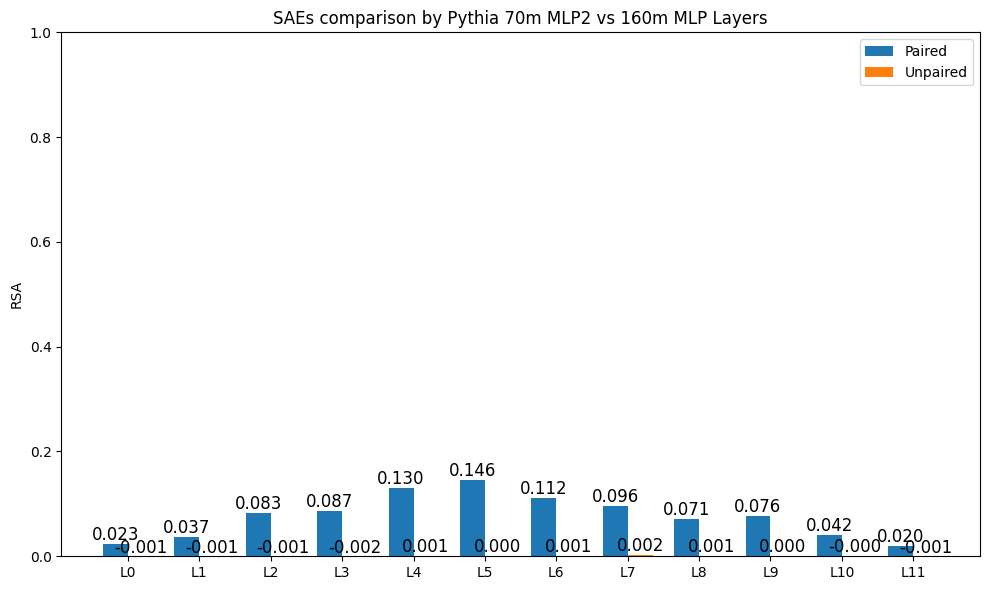

In [ ]:
plot_rsa_byLayer(layer_to_dictscores)

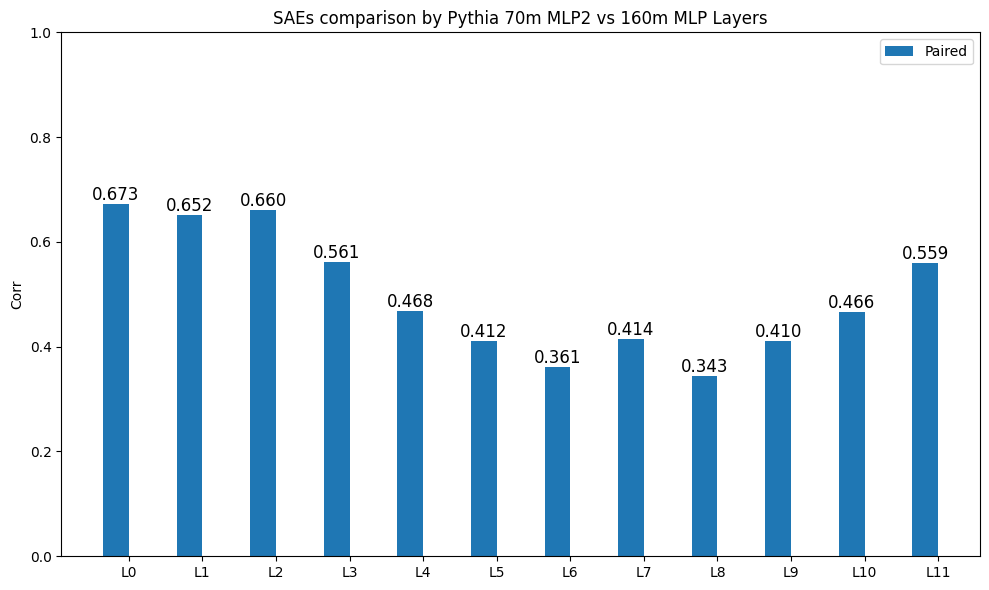

In [ ]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

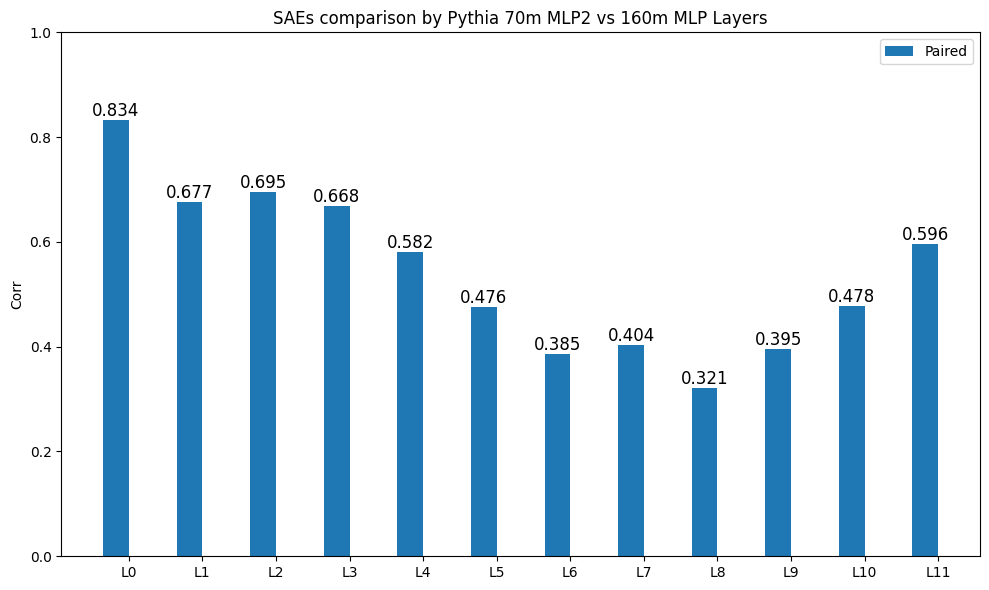

In [ ]:
plot_meanCorr_byLayer(layer_to_dictscores)

## test

In [77]:
layer_id = 2
layer_to_dictscores = run_expm(layer_id, outputs, outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.001800537109375
Layer: 0
mean_actv_corr: 0.0006693040484151425
num_feat_kept: 58
mean_actv_corr_filt: 0.3478865328020063
rsa_paired: 0.018511933825349217
rsa_unpaired: -0.006780828177905136




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.22381591796875
Layer: 1
mean_actv_corr: 0.6842851151490095
num_feat_kept: 7333
mean_actv_corr_filt: 0.6609875721843997
rsa_paired: 0.039998322226832236
rsa_unpaired: 0.001650799304894148




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.23333740234375
Layer: 2
mean_actv_corr: 0.6951166202568402
num_feat_kept: 7645
mean_actv_corr_filt: 0.6601237599379179
rsa_paired: 0.08288709819801347
rsa_unpaired: 0.00010260221548798246




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.16259765625
Layer: 3
mean_actv_corr: 0.7650287425578881
num_feat_kept: 5327
mean_actv_corr_filt: 0.5738974492685732
rsa_paired: 0.06862419308395816
rsa_unpaired: -0.0008885708455445752




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.249908447265625
Layer: 4
mean_actv_corr: 0.6040481315989155
num_feat_kept: 8188
mean_actv_corr_filt: 0.5464592071333796
rsa_paired: 0.1323881611376166
rsa_unpaired: -0.0008607430044802986




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.202484130859375
Layer: 5
mean_actv_corr: 0.6979668675628545
num_feat_kept: 6634
mean_actv_corr_filt: 0.5565809841625188
rsa_paired: 0.15380914767557333
rsa_unpaired: 6.2345034073069e-05




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.2249755859375
Layer: 6
mean_actv_corr: 0.5508694688767264
num_feat_kept: 7372
mean_actv_corr_filt: 0.45505864887406855
rsa_paired: 0.11202862107674737
rsa_unpaired: 0.00040454646922659674




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.283599853515625
Layer: 7
mean_actv_corr: 0.491836990148272
num_feat_kept: 9292
mean_actv_corr_filt: 0.49791223237477805
rsa_paired: 0.09489220347975372
rsa_unpaired: 0.0002447908087469905




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.259246826171875
Layer: 8
mean_actv_corr: 0.4228791827376881
num_feat_kept: 8494
mean_actv_corr_filt: 0.433581767365168
rsa_paired: 0.09982668048852587
rsa_unpaired: 0.00014271049401348062




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.23748779296875
Layer: 9
mean_actv_corr: 0.46057376988244414
num_feat_kept: 7781
mean_actv_corr_filt: 0.43871050025339436
rsa_paired: 0.08399840673621055
rsa_unpaired: 0.000400775179740543




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.20294189453125
Layer: 10
mean_actv_corr: 0.5198981349872156
num_feat_kept: 6649
mean_actv_corr_filt: 0.4195229582138923
rsa_paired: 0.05874043266139258
rsa_unpaired: -5.295875070303417e-05




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.156890869140625
Layer: 11
mean_actv_corr: 0.5607534909377137
num_feat_kept: 5140
mean_actv_corr_filt: 0.39091453907127105
rsa_paired: 0.03534472995745959
rsa_unpaired: 0.0006119292229568761




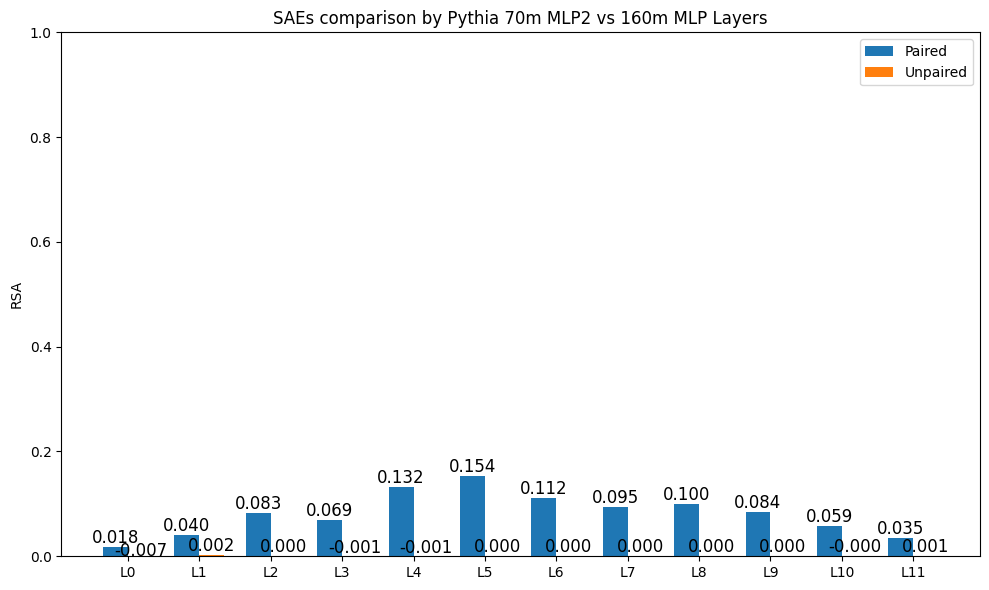

In [78]:
plot_rsa_byLayer(layer_to_dictscores)

# MLP 1

loop- 1-1

In [80]:
layer_id = 1
layer_to_dictscores = run_expm(layer_id, outputs, outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.00164794921875
Layer: 0
mean_actv_corr: 0.0007525277815148002
num_feat_kept: 53
mean_actv_corr_filt: 0.41320417638657225
rsa_paired: -0.01886404477434185
rsa_unpaired: 0.05054374923724829




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.286285400390625
Layer: 1
mean_actv_corr: 0.7342436149554032
num_feat_kept: 9380
mean_actv_corr_filt: 0.7232441162003447
rsa_paired: 0.04200749051947602
rsa_unpaired: -0.0015945286455270745




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.277740478515625
Layer: 2
mean_actv_corr: 0.689946781135859
num_feat_kept: 9100
mean_actv_corr_filt: 0.7005465462459968
rsa_paired: 0.0793630420947046
rsa_unpaired: 0.00043889140052121223




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.167266845703125
Layer: 3
mean_actv_corr: 0.6377067568580514
num_feat_kept: 5480
mean_actv_corr_filt: 0.5475927675428399
rsa_paired: 0.0792722028106701
rsa_unpaired: -0.00041078601018839874




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.27069091796875
Layer: 4
mean_actv_corr: 0.5614436359492174
num_feat_kept: 8869
mean_actv_corr_filt: 0.5579158087713714
rsa_paired: 0.10461008673452059
rsa_unpaired: -0.00016620711781317258




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.216156005859375
Layer: 5
mean_actv_corr: 0.6068001515562855
num_feat_kept: 7082
mean_actv_corr_filt: 0.5531062334849568
rsa_paired: 0.1252234077518267
rsa_unpaired: -7.187075868719509e-05




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.23602294921875
Layer: 6
mean_actv_corr: 0.4815405199262841
num_feat_kept: 7734
mean_actv_corr_filt: 0.44664096034040185
rsa_paired: 0.09435205468613686
rsa_unpaired: 0.0005937775763418054




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.29034423828125
Layer: 7
mean_actv_corr: 0.45426477784201325
num_feat_kept: 9513
mean_actv_corr_filt: 0.48174272428598486
rsa_paired: 0.0761407675217232
rsa_unpaired: 0.0007970581582608347




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.279510498046875
Layer: 8
mean_actv_corr: 0.3915375904047096
num_feat_kept: 9158
mean_actv_corr_filt: 0.42457550225588636
rsa_paired: 0.0720441040251924
rsa_unpaired: -0.0003533325898500112




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.25537109375
Layer: 9
mean_actv_corr: 0.4011780109868823
num_feat_kept: 8367
mean_actv_corr_filt: 0.430294333728173
rsa_paired: 0.06190901241449788
rsa_unpaired: 0.0005914622500640815




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.21649169921875
Layer: 10
mean_actv_corr: 0.44488529923876285
num_feat_kept: 7093
mean_actv_corr_filt: 0.412733655700235
rsa_paired: 0.045792723286250295
rsa_unpaired: 0.00035892642220694744




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.166961669921875
Layer: 11
mean_actv_corr: 0.45058832524114223
num_feat_kept: 5470
mean_actv_corr_filt: 0.3785733576094429
rsa_paired: 0.026047765077474083
rsa_unpaired: 0.0003107199817859693




In [81]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.0007525277815148002,
  'num_feat_kept': 53,
  'mean_actv_corr_filt': 0.41320417638657225,
  'rsa_paired': -0.01886404477434185,
  'rsa_unpaired': 0.05054374923724829},
 1: {'mean_actv_corr': 0.7342436149554032,
  'num_feat_kept': 9380,
  'mean_actv_corr_filt': 0.7232441162003447,
  'rsa_paired': 0.04200749051947602,
  'rsa_unpaired': -0.0015945286455270745},
 2: {'mean_actv_corr': 0.689946781135859,
  'num_feat_kept': 9100,
  'mean_actv_corr_filt': 0.7005465462459968,
  'rsa_paired': 0.0793630420947046,
  'rsa_unpaired': 0.00043889140052121223},
 3: {'mean_actv_corr': 0.6377067568580514,
  'num_feat_kept': 5480,
  'mean_actv_corr_filt': 0.5475927675428399,
  'rsa_paired': 0.0792722028106701,
  'rsa_unpaired': -0.00041078601018839874},
 4: {'mean_actv_corr': 0.5614436359492174,
  'num_feat_kept': 8869,
  'mean_actv_corr_filt': 0.5579158087713714,
  'rsa_paired': 0.10461008673452059,
  'rsa_unpaired': -0.00016620711781317258},
 5: {'mean_actv_corr': 0.60680015155

### plot

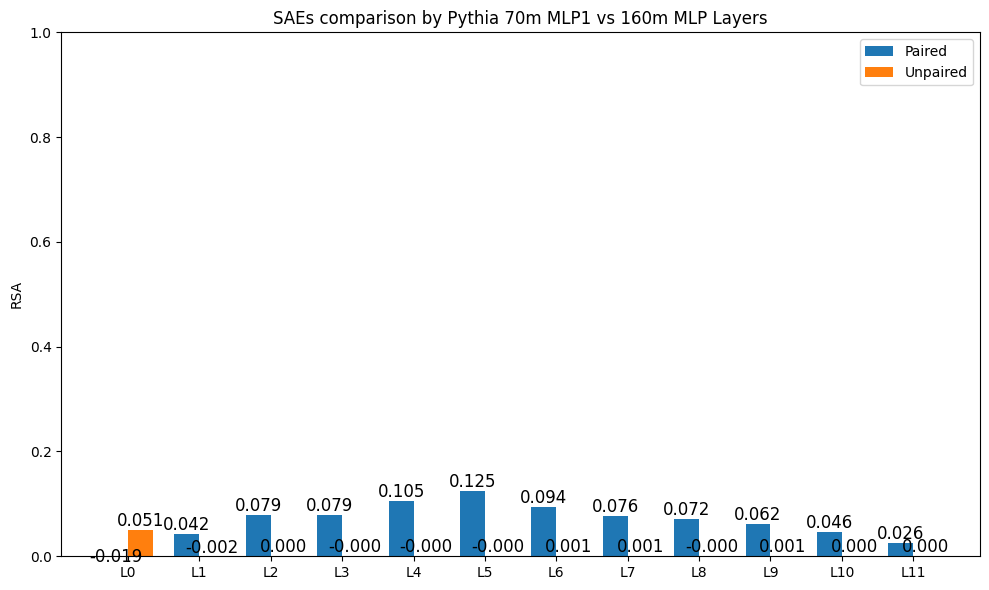

In [82]:
plot_rsa_byLayer(layer_to_dictscores)

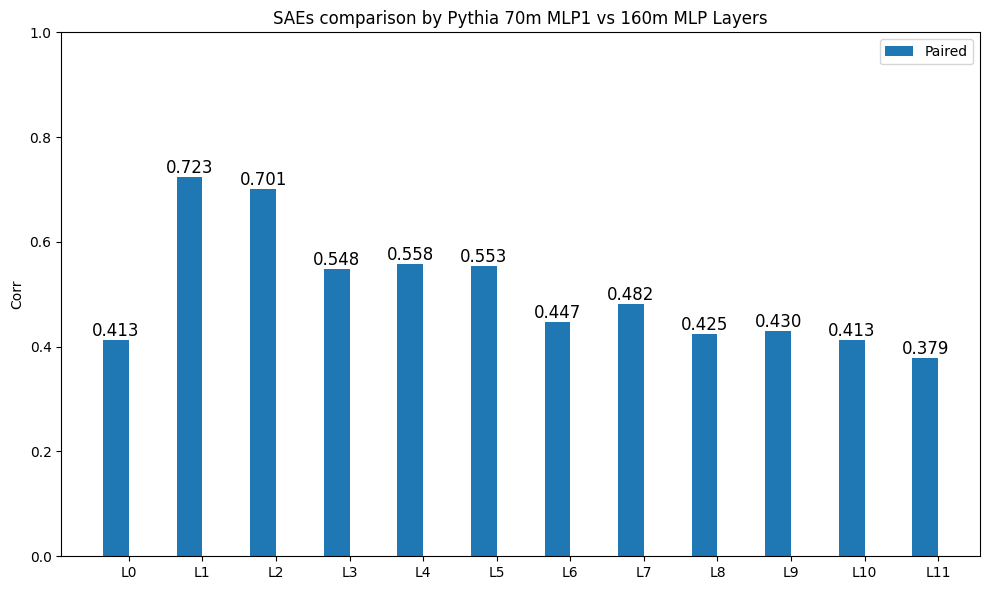

In [83]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

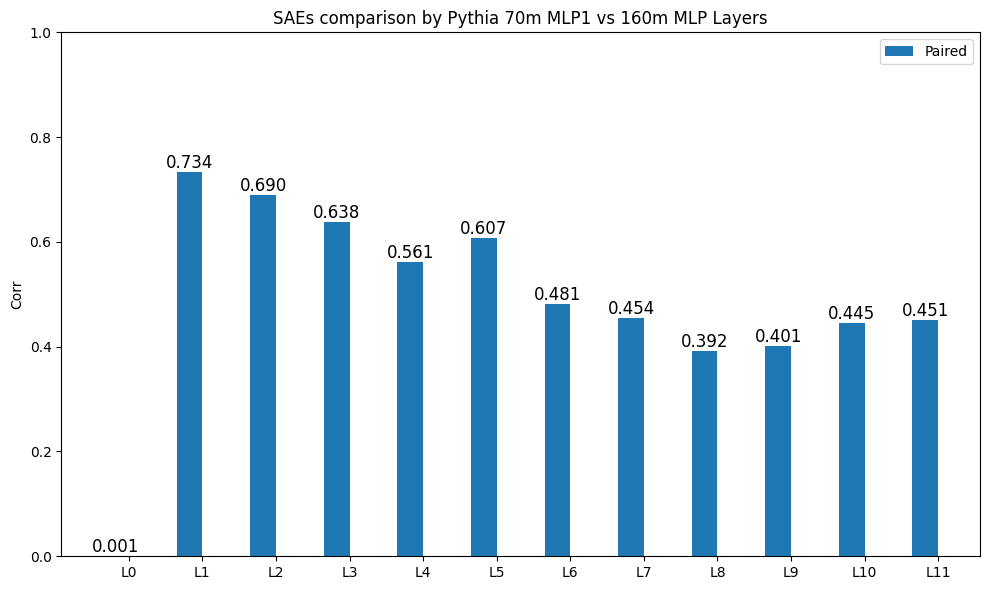

In [84]:
plot_meanCorr_byLayer(layer_to_dictscores)

In [86]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_kept'])

0 53
1 9380
2 9100
3 5480
4 8869
5 7082
6 7734
7 9513
8 9158
9 8367
10 7093
11 5470


# MLP 3

loop- 1-1

In [ ]:
layer_id = 3
layer_to_dictscores = run_expm(layer_id, outputs, outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Number of zero columns: 118


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.137054443359375
num feats after rmv 0s:  4491
Layer: 0
mean_actv_corr: 0.7714654523451827
num_feat_filt: 4491
mean_actv_corr_filt: 0.46409869696874445
rsa_paired: 0.023234231101462915
rsa_unpaired: -0.0002625877307121361




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.221771240234375
num feats after rmv 0s:  7267
Layer: 1
mean_actv_corr: 0.5244421204170067
num_feat_filt: 7267
mean_actv_corr_filt: 0.4758951673557149
rsa_paired: 0.034696848960025804
rsa_unpaired: 0.0007048670915177739




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.27197265625
num feats after rmv 0s:  8911
Layer: 2
mean_actv_corr: 0.5645263999672352
num_feat_filt: 8911
mean_actv_corr_filt: 0.5516893771162352
rsa_paired: 0.06719408901398555
rsa_unpaired: 0.00013186642993735234




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.128692626953125
num feats after rmv 0s:  4216
Layer: 3
mean_actv_corr: 0.7482116222133754
num_feat_filt: 4216
mean_actv_corr_filt: 0.5010968810530553
rsa_paired: 0.0923733017455497
rsa_unpaired: 0.00040758330983790706




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.077880859375
num feats after rmv 0s:  2552
Layer: 4
mean_actv_corr: 0.7551826054198045
num_feat_filt: 2552
mean_actv_corr_filt: 0.45460998758872195
rsa_paired: 0.13656857901056424
rsa_unpaired: 0.0003986446559117163




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.093475341796875
num feats after rmv 0s:  3062
Layer: 5
mean_actv_corr: 0.6812547447350426
num_feat_filt: 3062
mean_actv_corr_filt: 0.4020416456901856
rsa_paired: 0.17738028135188838
rsa_unpaired: 0.0006555723216276387




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.1015625
num feats after rmv 0s:  3327
Layer: 6
mean_actv_corr: 0.5035933595449933
num_feat_filt: 3327
mean_actv_corr_filt: 0.3083629742273705
rsa_paired: 0.1836767483629403
rsa_unpaired: 0.0004255554347461647




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.125152587890625
num feats after rmv 0s:  4101
Layer: 7
mean_actv_corr: 0.4641324124515904
num_feat_filt: 4101
mean_actv_corr_filt: 0.3299177857985644
rsa_paired: 0.17553074526378257
rsa_unpaired: -0.001128243961363502




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.090362548828125
num feats after rmv 0s:  2960
Layer: 8
mean_actv_corr: 0.3840626480443916
num_feat_filt: 2960
mean_actv_corr_filt: 0.2534286586844639
rsa_paired: 0.14956729296805932
rsa_unpaired: 4.3937755170914195e-05




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.093505859375
num feats after rmv 0s:  3063
Layer: 9
mean_actv_corr: 0.5040362091826864
num_feat_filt: 3063
mean_actv_corr_filt: 0.3089884181175207
rsa_paired: 0.11398941442038855
rsa_unpaired: -0.0016812161048523275




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.046875
num feats after rmv 0s:  1535
Layer: 10
mean_actv_corr: 0.7126475182108152
num_feat_filt: 1535
mean_actv_corr_filt: 0.35245130950833764
rsa_paired: 0.05811083911860681
rsa_unpaired: -0.001494308093944821




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.138153076171875
num feats after rmv 0s:  4526
Layer: 11
mean_actv_corr: 0.6343161644401789
num_feat_filt: 4526
mean_actv_corr_filt: 0.43982465931478193
rsa_paired: 0.031760442261375754
rsa_unpaired: 0.0003713602931372863




In [ ]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.7714654523451827,
  'num_feat_filt': 4491,
  'mean_actv_corr_filt': 0.46409869696874445,
  'rsa_paired': 0.023234231101462915,
  'rsa_unpaired': -0.0002625877307121361},
 1: {'mean_actv_corr': 0.5244421204170067,
  'num_feat_filt': 7267,
  'mean_actv_corr_filt': 0.4758951673557149,
  'rsa_paired': 0.034696848960025804,
  'rsa_unpaired': 0.0007048670915177739},
 2: {'mean_actv_corr': 0.5645263999672352,
  'num_feat_filt': 8911,
  'mean_actv_corr_filt': 0.5516893771162352,
  'rsa_paired': 0.06719408901398555,
  'rsa_unpaired': 0.00013186642993735234},
 3: {'mean_actv_corr': 0.7482116222133754,
  'num_feat_filt': 4216,
  'mean_actv_corr_filt': 0.5010968810530553,
  'rsa_paired': 0.0923733017455497,
  'rsa_unpaired': 0.00040758330983790706},
 4: {'mean_actv_corr': 0.7551826054198045,
  'num_feat_filt': 2552,
  'mean_actv_corr_filt': 0.45460998758872195,
  'rsa_paired': 0.13656857901056424,
  'rsa_unpaired': 0.0003986446559117163},
 5: {'mean_actv_corr': 0.681254744

### plot

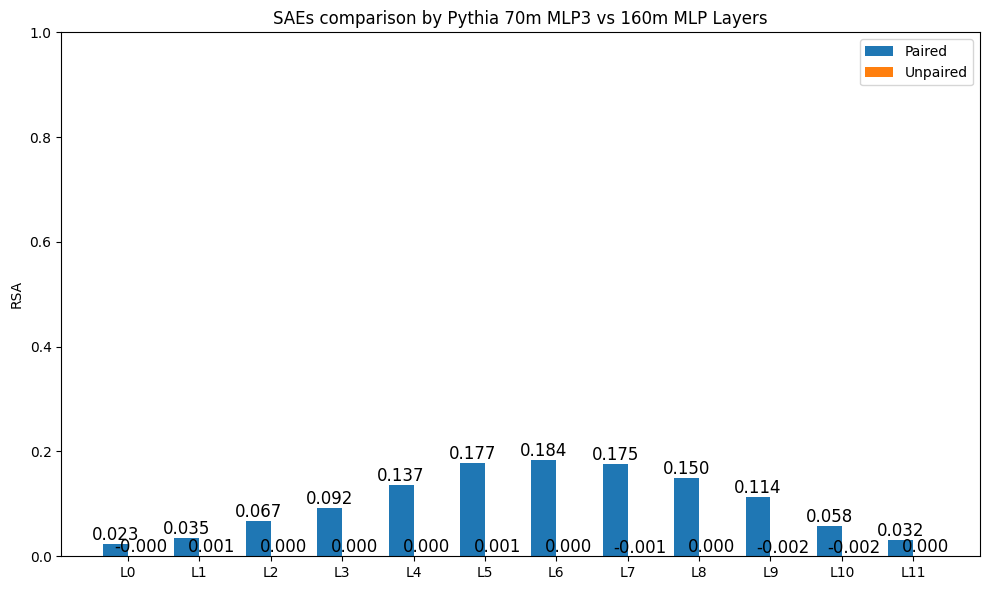

In [ ]:
plot_rsa_byLayer(layer_to_dictscores)

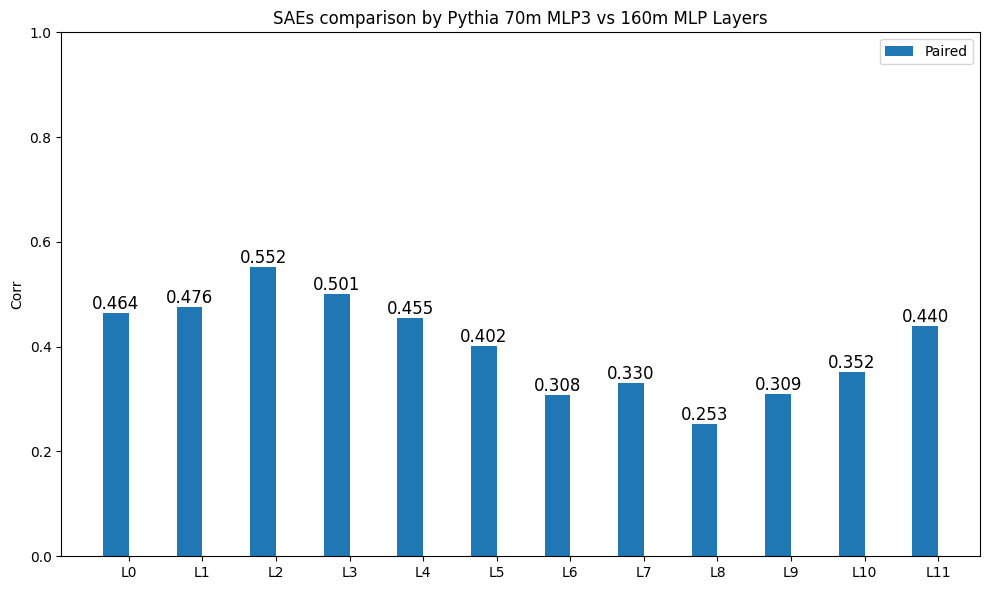

In [ ]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

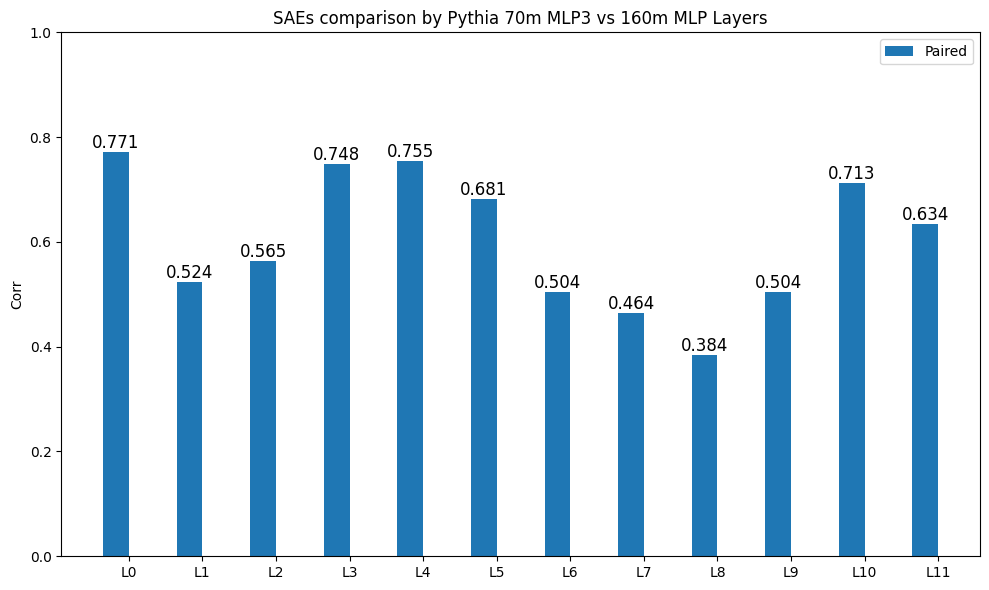

In [ ]:
plot_meanCorr_byLayer(layer_to_dictscores)

In [ ]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_filt'])

0 4491
1 7267
2 8911
3 4216
4 2552
5 3062
6 3327
7 4101
8 2960
9 3063
10 1535
11 4526


# MLP 4

loop- 1-1

In [87]:
layer_id = 1
layer_to_dictscores = run_expm(layer_id, outputs, outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.00164794921875
Layer: 0
mean_actv_corr: 0.0007525277815148002
num_feat_kept: 53
mean_actv_corr_filt: 0.41320417638657225
rsa_paired: -0.01886404477434185
rsa_unpaired: -0.015924780339056033




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.286285400390625
Layer: 1
mean_actv_corr: 0.7342436149554032
num_feat_kept: 9380
mean_actv_corr_filt: 0.7232441162003447
rsa_paired: 0.04200749051947602
rsa_unpaired: -0.00020904898975169546




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.277740478515625
Layer: 2
mean_actv_corr: 0.689946781135859
num_feat_kept: 9100
mean_actv_corr_filt: 0.7005465462459968
rsa_paired: 0.0793630420947046
rsa_unpaired: 0.00018416520230254448




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.167266845703125
Layer: 3
mean_actv_corr: 0.6377067568580514
num_feat_kept: 5480
mean_actv_corr_filt: 0.5475927675428399
rsa_paired: 0.0792722028106701
rsa_unpaired: 0.0006483878048036523




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.27069091796875
Layer: 4
mean_actv_corr: 0.5614436359492174
num_feat_kept: 8869
mean_actv_corr_filt: 0.5579158087713714
rsa_paired: 0.10461008673452059
rsa_unpaired: -0.0011548040851354186




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.216156005859375
Layer: 5
mean_actv_corr: 0.6068001515562855
num_feat_kept: 7082
mean_actv_corr_filt: 0.5531062334849568
rsa_paired: 0.1252234077518267
rsa_unpaired: 0.00011832241049285894




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.23602294921875
Layer: 6
mean_actv_corr: 0.4815405199262841
num_feat_kept: 7734
mean_actv_corr_filt: 0.44664096034040185
rsa_paired: 0.09435205468613686
rsa_unpaired: -0.0008650640184731226




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.29034423828125
Layer: 7
mean_actv_corr: 0.45426477784201325
num_feat_kept: 9513
mean_actv_corr_filt: 0.48174272428598486
rsa_paired: 0.0761407675217232
rsa_unpaired: 0.0013492411857397163




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.279510498046875
Layer: 8
mean_actv_corr: 0.3915375904047096
num_feat_kept: 9158
mean_actv_corr_filt: 0.42457550225588636
rsa_paired: 0.0720441040251924
rsa_unpaired: 0.0011404152539250438




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.25537109375
Layer: 9
mean_actv_corr: 0.4011780109868823
num_feat_kept: 8367
mean_actv_corr_filt: 0.430294333728173
rsa_paired: 0.06190901241449788
rsa_unpaired: 4.349462461503682e-05




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.21649169921875
Layer: 10
mean_actv_corr: 0.44488529923876285
num_feat_kept: 7093
mean_actv_corr_filt: 0.412733655700235
rsa_paired: 0.045792723286250295
rsa_unpaired: -0.000459029114646105




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.166961669921875
Layer: 11
mean_actv_corr: 0.45058832524114223
num_feat_kept: 5470
mean_actv_corr_filt: 0.3785733576094429
rsa_paired: 0.026047765077474083
rsa_unpaired: 0.00040461184561549183




In [88]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.0007525277815148002,
  'num_feat_kept': 53,
  'mean_actv_corr_filt': 0.41320417638657225,
  'rsa_paired': -0.01886404477434185,
  'rsa_unpaired': -0.015924780339056033},
 1: {'mean_actv_corr': 0.7342436149554032,
  'num_feat_kept': 9380,
  'mean_actv_corr_filt': 0.7232441162003447,
  'rsa_paired': 0.04200749051947602,
  'rsa_unpaired': -0.00020904898975169546},
 2: {'mean_actv_corr': 0.689946781135859,
  'num_feat_kept': 9100,
  'mean_actv_corr_filt': 0.7005465462459968,
  'rsa_paired': 0.0793630420947046,
  'rsa_unpaired': 0.00018416520230254448},
 3: {'mean_actv_corr': 0.6377067568580514,
  'num_feat_kept': 5480,
  'mean_actv_corr_filt': 0.5475927675428399,
  'rsa_paired': 0.0792722028106701,
  'rsa_unpaired': 0.0006483878048036523},
 4: {'mean_actv_corr': 0.5614436359492174,
  'num_feat_kept': 8869,
  'mean_actv_corr_filt': 0.5579158087713714,
  'rsa_paired': 0.10461008673452059,
  'rsa_unpaired': -0.0011548040851354186},
 5: {'mean_actv_corr': 0.60680015155

### plot

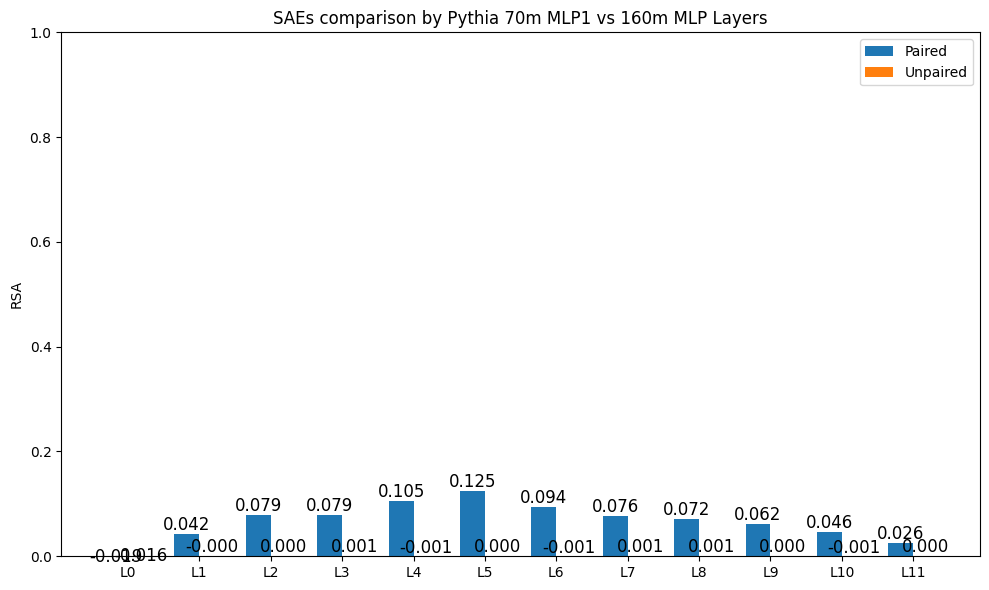

In [89]:
plot_rsa_byLayer(layer_to_dictscores)

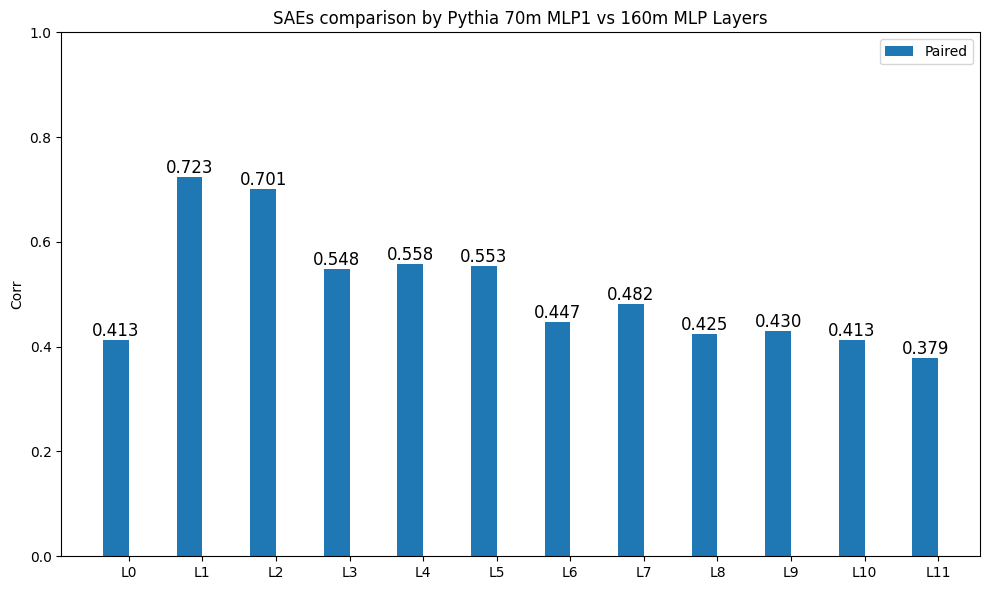

In [90]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

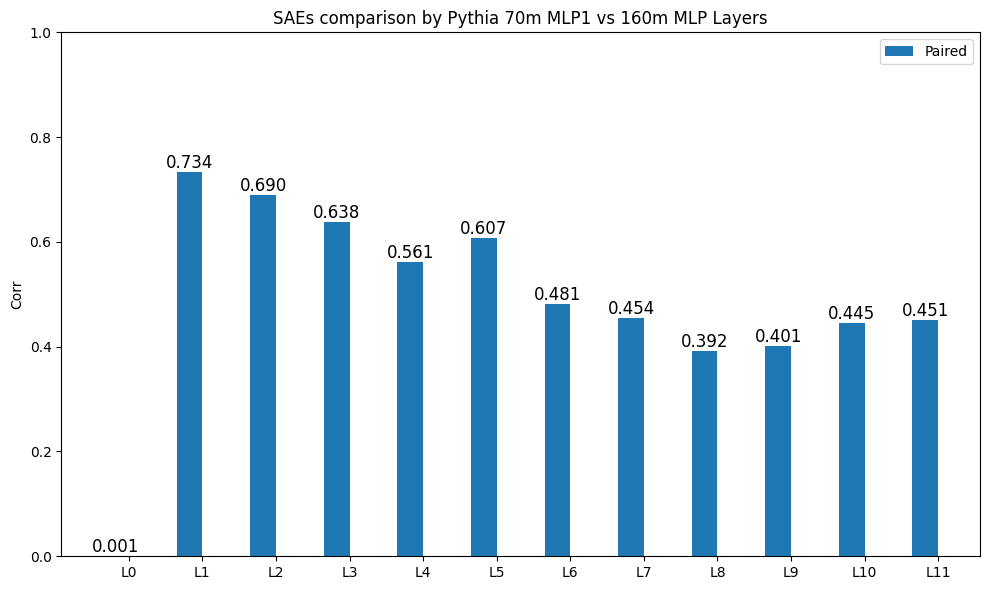

In [91]:
plot_meanCorr_byLayer(layer_to_dictscores)

In [92]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_kept'])

0 53
1 9380
2 9100
3 5480
4 8869
5 7082
6 7734
7 9513
8 9158
9 8367
10 7093
11 5470


# MLP 5

loop- 1-1

In [ ]:
layer_id = 5
layer_to_dictscores = run_expm(layer_id, outputs, outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Number of zero columns: 139


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.13580322265625
num feats after rmv 0s:  4450
Layer: 0
mean_actv_corr: 0.6399477781030782
num_feat_filt: 4450
mean_actv_corr_filt: 0.37289896169237874
rsa_paired: 0.0034991958743956874
rsa_unpaired: 0.0010170522497440094




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.16845703125
num feats after rmv 0s:  5520
Layer: 1
mean_actv_corr: 0.3195505480326801
num_feat_filt: 5520
mean_actv_corr_filt: 0.3130455806493705
rsa_paired: 0.007571733758782786
rsa_unpaired: -0.0004287611219214503




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.175933837890625
num feats after rmv 0s:  5764
Layer: 2
mean_actv_corr: 0.29479954633961825
num_feat_filt: 5764
mean_actv_corr_filt: 0.28105391097939486
rsa_paired: 0.01715855233327221
rsa_unpaired: 0.0004689661316382524




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.212921142578125
num feats after rmv 0s:  6976
Layer: 3
mean_actv_corr: 0.3328287333724802
num_feat_filt: 6976
mean_actv_corr_filt: 0.30595974475674015
rsa_paired: 0.022562312759276698
rsa_unpaired: -0.00032902234909853697




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.217254638671875
num feats after rmv 0s:  7118
Layer: 4
mean_actv_corr: 0.329717890045913
num_feat_filt: 7118
mean_actv_corr_filt: 0.29765311197853217
rsa_paired: 0.029544135279955704
rsa_unpaired: -5.474259463231671e-05




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.173370361328125
num feats after rmv 0s:  5680
Layer: 5
mean_actv_corr: 0.6621008103410304
num_feat_filt: 5680
mean_actv_corr_filt: 0.4227802016464075
rsa_paired: 0.045952993856810835
rsa_unpaired: -6.812149813254593e-05




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.170196533203125
num feats after rmv 0s:  5576
Layer: 6
mean_actv_corr: 0.6003557477700951
num_feat_filt: 5576
mean_actv_corr_filt: 0.4127430948442172
rsa_paired: 0.03159858835116627
rsa_unpaired: 0.00033756621887453804




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.182098388671875
num feats after rmv 0s:  5966
Layer: 7
mean_actv_corr: 0.5562490744024444
num_feat_filt: 5966
mean_actv_corr_filt: 0.4073507762137842
rsa_paired: 0.03331188853355711
rsa_unpaired: -1.4137395143251123e-05




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.14825439453125
num feats after rmv 0s:  4857
Layer: 8
mean_actv_corr: 0.5200536348048672
num_feat_filt: 4857
mean_actv_corr_filt: 0.360078808374278
rsa_paired: 0.025507643854816853
rsa_unpaired: -0.0005875744578576933




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.109771728515625
num feats after rmv 0s:  3596
Layer: 9
mean_actv_corr: 0.7180895000348073
num_feat_filt: 3596
mean_actv_corr_filt: 0.38469257156309716
rsa_paired: 0.01731876911044462
rsa_unpaired: -0.000632083567754066




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.071990966796875
num feats after rmv 0s:  2358
Layer: 10
mean_actv_corr: 0.8752770388724684
num_feat_filt: 2358
mean_actv_corr_filt: 0.5123467141520659
rsa_paired: 0.013725099548026717
rsa_unpaired: 0.0011864513856109224




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.146697998046875
num feats after rmv 0s:  4806
Layer: 11
mean_actv_corr: 0.661913313214427
num_feat_filt: 4806
mean_actv_corr_filt: 0.35924809314372563
rsa_paired: 0.02587662511705417
rsa_unpaired: 0.00017609656201989334




In [ ]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.6399477781030782,
  'num_feat_filt': 4450,
  'mean_actv_corr_filt': 0.37289896169237874,
  'rsa_paired': 0.0034991958743956874,
  'rsa_unpaired': 0.0010170522497440094},
 1: {'mean_actv_corr': 0.3195505480326801,
  'num_feat_filt': 5520,
  'mean_actv_corr_filt': 0.3130455806493705,
  'rsa_paired': 0.007571733758782786,
  'rsa_unpaired': -0.0004287611219214503},
 2: {'mean_actv_corr': 0.29479954633961825,
  'num_feat_filt': 5764,
  'mean_actv_corr_filt': 0.28105391097939486,
  'rsa_paired': 0.01715855233327221,
  'rsa_unpaired': 0.0004689661316382524},
 3: {'mean_actv_corr': 0.3328287333724802,
  'num_feat_filt': 6976,
  'mean_actv_corr_filt': 0.30595974475674015,
  'rsa_paired': 0.022562312759276698,
  'rsa_unpaired': -0.00032902234909853697},
 4: {'mean_actv_corr': 0.329717890045913,
  'num_feat_filt': 7118,
  'mean_actv_corr_filt': 0.29765311197853217,
  'rsa_paired': 0.029544135279955704,
  'rsa_unpaired': -5.474259463231671e-05},
 5: {'mean_actv_corr': 0.66

### plot

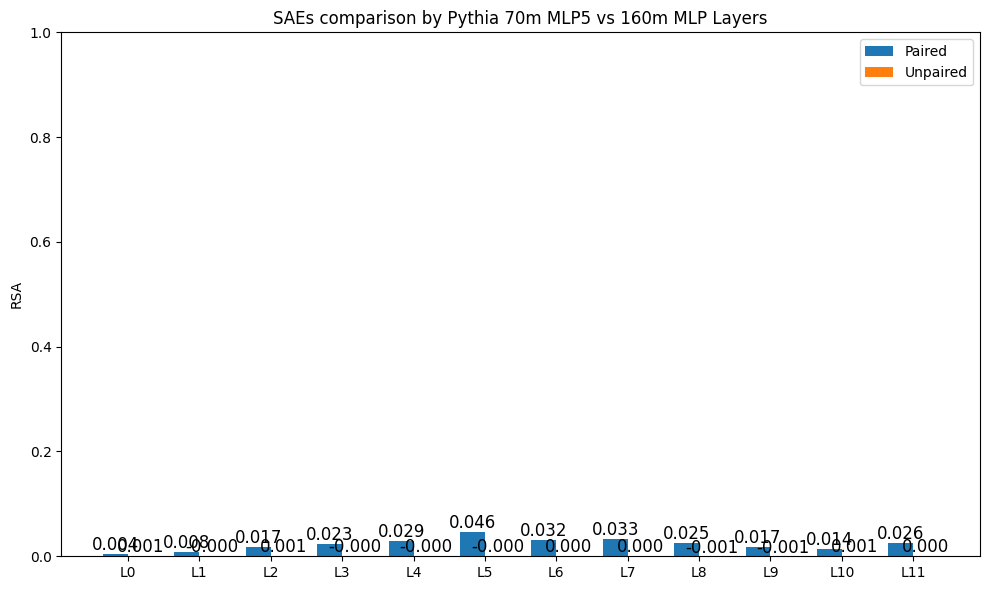

In [ ]:
plot_rsa_byLayer(layer_to_dictscores)

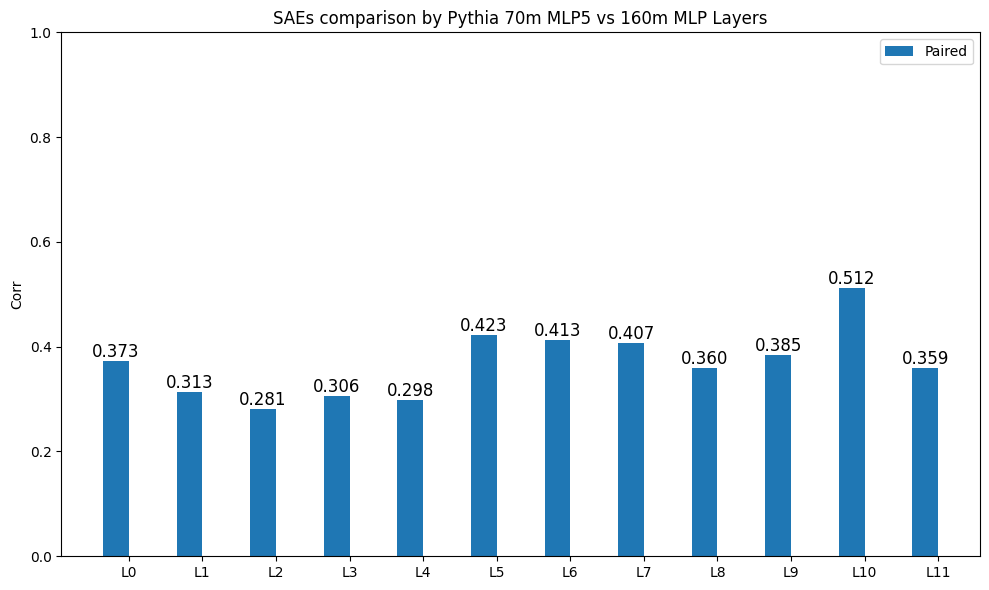

In [ ]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

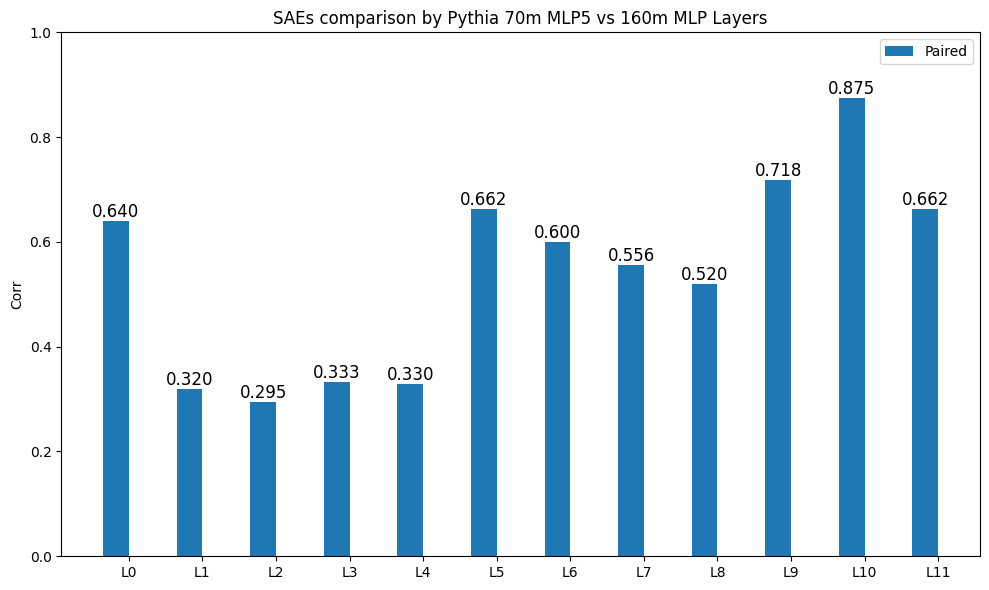

In [ ]:
plot_meanCorr_byLayer(layer_to_dictscores)

In [ ]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_filt'])

0 4450
1 5520
2 5764
3 6976
4 7118
5 5680
6 5576
7 5966
8 4857
9 3596
10 2358
11 4806
